# Detrend and deseasonalize datasets

In [1]:
import os
import sys
import json
from itertools import product
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import matplotlib.pyplot as plt

sys.path.append('..')
import utils

In [2]:
with open('../paths.json') as paths_json:
    PATHS = json.load(paths_json)
    
with open('../globals.json') as globals_json:
    GLOBALS = json.load(globals_json)
    
FILE = os.path.join(os.path.abspath('.'), 'detrend_deseasonalize.ipynb')

VARIABLES = ['SSH', 'zos', 'SST', 'PSL', 'UBOT', 'VBOT', 'SHFLX']
VARIABLES = ['SHF', 'MLD']

In [3]:
def detrend(arr, dim='time', deg=5):
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        p = arr.polyfit(dim=dim, deg=deg)
    p['polyfit_coefficients'] = p['polyfit_coefficients'].chunk(
        {'lat': 48, 'lon': 48}
    )
    trend = xr.polyval(arr[dim], p['polyfit_coefficients'])
    detrended = arr - trend
    
    detrended.name = arr.name
    detrended.attrs['units'] = arr.attrs['units']
    detrended.attrs['description'] = (
        f"Detrended {arr.name} using a degree {deg} polynomial."
    )
    detrended.attrs['history'] = (
        f"Created on {datetime.now()} using {FILE}"
    )
    return detrended

def deseasonalize(arr):
    if len(arr['time']) == 0:
        return arr
    gb = arr.groupby('time.dayofyear')
    clim = gb.mean(dim='time')
    anom = (gb - clim).drop_vars('dayofyear')
    return anom

In [4]:
cluster = PBSCluster(walltime='03:30:00', memory='32GB')
client = Client(cluster)
cluster.scale(16)
client.dashboard_link

'https://jupyterhub.hpc.ucar.edu/stable/user/abrettin/proxy/8787/status'

Testing
* We will also do some benchmarking with different numbers of resources to optimize our computation.

In [4]:
var = 'SSH'
init_year = 1251
member = '013'
ssh = utils.data.load_dataset(var, init_year, member, chunkedby='time')

In [6]:
ssh

<xarray.DataArray 'SSH' (lat: 192, lon: 288, time: 91615)>
dask.array<open_dataset-2237d6c00d7a6d36de7e3fcfb19a335bSSH, shape=(192, 288, 91615), dtype=float64, chunksize=(48, 48, 91615), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-02 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    description:  Effective sea level, including the inverse-barometer contri...
    history:      Created on 2023-01-23 18:56:28.199413 using /glade/u/home/a...
    long_name:    effective_sea_level
    units:        m

In [9]:
START_TIME = datetime.now()
print(f"LE-{init_year}.{member}.{var}")
print(datetime.now() - START_TIME)

# Load data
arr = utils.data.load_dataset(var, init_year, member, chunkedby='time')

# Detrend
print("Detrending data")
print(datetime.now() - START_TIME)
detrended = detrend(arr)

# Deseasonalize
print("Deseasonalizing data")
print(datetime.now() - START_TIME)
anom = xr.map_blocks(deseasonalize, detrended, template=detrended)
anom.name = arr.name
anom.attrs['units'] = arr.attrs['units']
anom.attrs['description'] = (
    f"Deseasonalized {arr.name} using daily mean climatology."
)
anom.attrs['history'] = (
    f"Created on {datetime.now()} using {FILE}"
)

# Create dataset and save
print("Saving data")
print(datetime.now() - START_TIME)

ds = xr.Dataset({var: anom})
path = os.path.join(
    PATHS['tmp'],
    f'temp.zarr'
)
ds.to_zarr(path)

# Rinse and repeat
print("Data saved")
print(datetime.now() - START_TIME, '\n')

LE-1251.013.SSH
0:00:00.000091
Detrending data
0:00:00.393966
Deseasonalizing data
0:00:00.947891
Saving data
0:00:10.730935
Data saved
0:02:16.061952 



In [12]:
ds = xr.open_zarr(path, consolidated=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 91615)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-02 00:00:00 ... 2101-01-01 00:00:00
Data variables:
    SSH      (lat, lon, time) float64 dask.array<chunksize=(48, 48, 91615), meta=np.ndarray>

In [13]:
timeseries = ds['SSH'].sel(lat=0, lon=0, method='nearest')

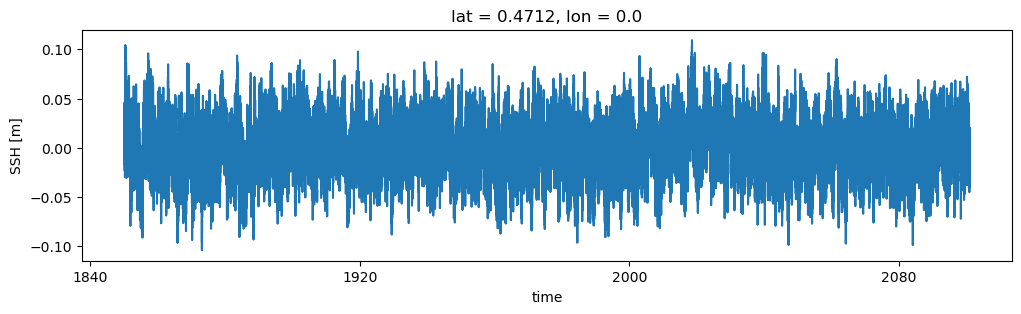

In [17]:
fig, ax = plt.subplots(figsize=(12,3))
timeseries.plot()

---

In [5]:
def main():
    START_TIME = datetime.now()
    for var, init_year, member in product(
            VARIABLES, GLOBALS['init_years'], GLOBALS['members']):
        print(f"LE-{init_year}.{member}.{var}")
        print(datetime.now() - START_TIME)
        
        # Load data
        arr = utils.data.load_dataset(var, init_year, member, chunkedby='time')
        
        # Detrend
        print("Detrending data")
        print(datetime.now() - START_TIME)
        detrended = detrend(arr)
        
        # Deseasonalize
        print("Deseasonalizing data")
        print(datetime.now() - START_TIME)
        anom = xr.map_blocks(deseasonalize, detrended, template=detrended)
        anom.name = arr.name
        anom.attrs['units'] = arr.attrs['units']
        anom.attrs['description'] = (
            f"Deseasonalized {arr.name} using daily mean climatology."
        )
        anom.attrs['history'] = (
            f"Created on {datetime.now()} using {FILE}"
        )
        
        # Create dataset and save
        print("Saving data")
        print(datetime.now() - START_TIME)
        
        ds = xr.Dataset({var: anom})
        path = os.path.join(
            PATHS['detrended_deseasonalized'],
            f'LE2-{init_year}.{member}.{var}_anom.zarr'
        )
        ds.to_zarr(path)
        
        # Rinse and repeat
        print("Data saved")
        client.restart()
        print(datetime.now() - START_TIME, '\n')
        
    print("PROCESS COMPLETED")
    print(datetime.now() - START_TIME)
    return 0

In [11]:
main()

LE-1251.011.SSH
0:00:00.000037
Detrending data
0:00:00.492210
Deseasonalizing data
0:00:01.040802
Saving data
0:00:13.269837
Data saved
0:01:58.514650 

LE-1251.012.SSH
0:01:58.514729
Detrending data
0:01:58.980058
Deseasonalizing data
0:01:59.722759
Saving data
0:02:10.759527
Data saved
0:03:50.623038 

LE-1251.013.SSH
0:03:50.623119
Detrending data
0:03:50.887365
Deseasonalizing data
0:03:51.605239
Saving data
0:04:04.947718
Data saved
0:05:47.691376 

LE-1281.011.SSH
0:05:47.691463
Detrending data
0:05:47.972603
Deseasonalizing data
0:05:48.634387
Saving data
0:06:00.901130
Data saved
0:07:39.469386 

LE-1281.012.SSH
0:07:39.469454
Detrending data
0:07:39.730602
Deseasonalizing data
0:07:40.388795
Saving data
0:07:51.591487
Data saved
0:09:32.388523 

LE-1281.013.SSH
0:09:32.388587
Detrending data
0:09:32.673284
Deseasonalizing data
0:09:33.324191
Saving data
0:09:44.755189
Data saved
0:11:20.481526 

LE-1301.011.SSH
0:11:20.481593
Detrending data
0:11:20.770488
Deseasonalizing data

0

In [7]:
main()

LE-1251.011.SHF
0:00:00.000042
Detrending data
0:00:00.194622
Deseasonalizing data
0:00:00.736553
Saving data
0:00:11.136423


$WORK/conda-envs/ml/lib/python3.8/site-packages/distributed/worker.py:3040: UserWarning: Large object of size 5.07 MiB detected in task graph: 
  ([('time',), <xarray.IndexVariable 'time' (time: 9 ... =object), {}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Data saved
0:02:22.263575 

LE-1251.012.SHF
0:02:22.263649
Detrending data
0:02:22.822501
Deseasonalizing data
0:02:23.452463
Saving data
0:02:33.174394
Data saved
0:04:40.625488 

LE-1251.013.SHF
0:04:40.625564
Detrending data
0:04:41.202162
Deseasonalizing data
0:04:42.042364
Saving data
0:04:53.703748
Data saved
0:07:19.899614 

LE-1281.011.SHF
0:07:19.899705
Detrending data
0:07:20.166903
Deseasonalizing data
0:07:20.772263
Saving data
0:07:33.603267
Data saved
0:09:48.310069 

LE-1281.012.SHF
0:09:48.311198
Detrending data
0:09:48.552837
Deseasonalizing data
0:09:49.113936
Saving data
0:10:00.663708
Data saved
0:12:24.964715 

LE-1281.013.SHF
0:12:24.964786
Detrending data
0:12:25.483139
Deseasonalizing data
0:12:26.065805
Saving data
0:12:36.055639
Data saved
0:14:41.361337 

LE-1301.011.SHF
0:14:41.361408
Detrending data
0:14:41.598655
Deseasonalizing data
0:14:42.184525
Saving data
0:14:52.366892
Data saved
0:17:13.869938 

LE-1301.012.SHF
0:17:13.870001
Detrending data
0:17:14

0

In [8]:
client.close()
cluster.close()